# Network-based Gene Prioritization from GWAS Data
MED283: Network Biology & Biomedicine  
Nadia Arang & Kevin Chau

TODO:
1. Map rescores to old gene summaries table
2. SNP assignment according to regression analysis

In [1]:
%matplotlib inline

import ndex2
import math
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Initial data loading

GIANT
> Greene CS*, Krishnan A*, Wong AK*, Ricciotti E, Zelaya RA, Himmelstein DS, Zhang R, Hartmann BM, Zaslavsky E, Sealfon SC, Chasman DI, FitzGerald GA, Dolinski K, Grosser T, Troyanskaya OG. (2015). Understanding multicellular function and disease with human tissue-specific networks. Nature Genetics. 10.1038/ng.3259w.

PCNet
> Huang JK*, Carlin DE*, Yu MK, Zhang W, Kreisberg JF, Tamayo P, Ideker T. (2018). Systematic Evaluation of Molecular Networks for Discovery of Disease Genes. Cell Systems. 4 (6): 484-495.e5. doi: 10.1016/j.cels.2018.03.001

In [2]:
# Load network from server
# PCNet
# pc_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
#                                            uuid = "f93f402c-86d4-11e7-a10d-0ac135e8bacf")

# GIANT; Brain-specific, 0.2-confidence filter
bn_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
                                           uuid = "19677bff-6037-11e8-a4bf-0ac135e8bacf")

In [3]:
# Cast as networkx object
# First cast to pandas since networkx 2.1 is incompatible with ndex2
# nt_pd = pc_nice.to_pandas_dataframe()
nt_pd = bn_nice.to_pandas_dataframe()
net = nx.from_pandas_edgelist(nt_pd)

In [4]:
# Load gene summary table
gene_summaries_given = pd.read_csv("../src/gene_level_summary_stats_pmid_25056061.txt", 
                                   header = 0, sep = '\t', index_col = 1)
gene_summaries_given.head()

,Unnamed: 0,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
Gene,,,,,,,,,
HIST1H4K,5905,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
HIST1H2AK,5867,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
HIST1H2BN,5883,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
HIST1H2AL,5868,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
HIST1H1B,5855,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


Text(0.5,0,'Chromosome')

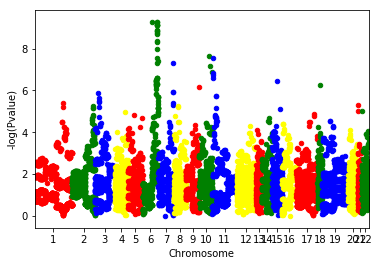

In [5]:
# Quick Manhattan plot
gs_man = gene_summaries_given
gs_man["-log(Pvalue)"] = -np.log10(gene_summaries_given["TopSNP P-Value"])
gs_man["Chr"] = gene_summaries_given["Chr"].astype("category")
gs_man = gene_summaries_given.sort_values("Chr")

gs_man["ind"] = range(len(gs_man))
gs_groups = gs_man.groupby(("Chr"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["red", "green", "blue", "yellow"]

x_labels = []
x_labels_pos = []

for num, (name, group) in enumerate(gs_groups):
    group.plot(kind = "scatter", x = "ind", y = "-log(Pvalue)", color = colors[num % len(colors)], ax = ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(gs_man)])
# ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')

In [6]:
# Load snp summary table
snp_summaries = pd.read_csv("../src/snp_level_summary_stats_pmid_25056061.txt", 
                            header = 0, sep = '\t', index_col = 0, na_values = ".")
snp_summaries.head()

,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
snpid,,,,,,,,,,
rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.160550
rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,NaN
rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.092593


### Gene significance by normalized p-value

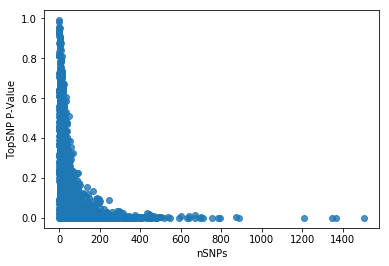

In [7]:
# Rationale
fig2 = plt.figure()
ax = fig2.add_subplot(111)
sns.regplot((gene_summaries_given["nSNPs"]), (gene_summaries_given["TopSNP P-Value"]), fit_reg = False)
#ax.set_ylim(-0.3, 1)

In [8]:
fig2.savefig("../data/gene_snp_correlation")

In [9]:
from scipy.stats import pearsonr
pearsonr(gene_summaries_given["nSNPs"], gene_summaries_given["TopSNP P-Value"])

(-0.20155646638624297, 5.578098517955562e-137)

There is clear correlation between number of captured SNPs and the assigned TopSNP p-value, so we should probably normalize gene score by number of captured SNPs

In [10]:
# Assign SNPs to genes based on +/- nkb window
nkb = 10

# Init new gene_summaries dataframe
gene_summaries = gene_summaries_given.loc[:, ["Chr", "Gene Start", "Gene End"]]
gene_summaries.head()

,Chr,Gene Start,Gene End
Gene,,,
HIST1H4K,6,27906930,27907284
HIST1H2AK,6,27913636,27914096
HIST1H2BN,6,27914418,27914867
HIST1H2AL,6,27941085,27941555
HIST1H1B,6,27942548,27943338


In [11]:
gene_scores = []
snp_counts = []
min_p = []
for gidx, gene in gene_summaries.iterrows():
    chrom = gene["Chr"]
    
    # filter for chromosome
    this_snps = snp_summaries[snp_summaries["hg18chr"] == chrom]
    
    # filter for upstream endpoint
    this_snps = this_snps[this_snps["bp"] >= gene["Gene Start"] - (nkb * 1000)]
    
    # filter for downstream endpoint
    this_snps = this_snps[this_snps["bp"] <= gene["Gene End"] + (nkb * 1000)]
    
    # Calculate adjusted bonferroni-adjusted p-value -> "gene score"
    # pvals = [p * snp_summaries.shape[0] for p in this_snps.loc[:, "pval"].tolist()]
    pvals = [p for p in this_snps.loc[:, "pval"].tolist()]
    adj_score = min(pvals) / len(pvals)
    min_p.append(min(pvals))
    gene_scores.append(adj_score)
    snp_counts.append(len(pvals))
gene_summaries["Gene Score"] = -np.log(gene_scores)
gene_summaries["nSNPs"] = snp_counts
gene_summaries["TopSNP P-Value"] = min_p

In [12]:
gene_summaries.head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value
Gene,,,,,,
HIST1H4K,6,27906930,27907284,23.481719,8,5.071180e-10
HIST1H2AK,6,27913636,27914096,24.174866,16,5.071180e-10
HIST1H2BN,6,27914418,27914867,24.235491,17,5.071180e-10
HIST1H2AL,6,27941085,27941555,23.374871,10,7.053790e-10
HIST1H1B,6,27942548,27943338,23.374871,10,7.053790e-10


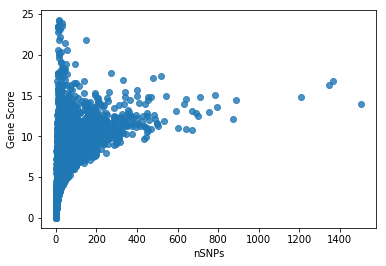

In [13]:
# Plot the gene rescore vs nSNPs
fig_rescore = plt.figure()
ax = fig_rescore.add_subplot(111)
sns.regplot(gene_summaries["nSNPs"], gene_summaries["Gene Score"], fit_reg = False)

In [14]:
fig_rescore.savefig("../data/gene_score_correlation.png")

In [15]:
pearsonr(gene_summaries["nSNPs"], gene_summaries["Gene Score"])

(0.46740209322671267, 0.0)

In [16]:
# Compare new gene list to given
glist_new = gene_summaries.sort_values(by = ["Gene Score"], ascending = False).index.tolist()[::-1]

In [17]:
glist_old = gene_summaries_given.sort_values(by = ["TopSNP P-Value"]).index.tolist()

In [18]:
spearmanr(glist_new, glist_old)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=0.00568456847220346, pvalue=0.48682179646626833)

In [19]:
gene_summaries[gene_summaries["Gene Score"] >= -math.log(0.00000005)].shape

(54, 6)

### Adding information to the network

In [20]:
nx.set_node_attributes(net, values = gene_summaries.T.to_dict())

### Overlapping the data

In [21]:
overlap_nodes = set(net.nodes) & set(gene_summaries.index)

In [22]:
len(overlap_nodes)

9896

In [23]:
net_distinct = [_ for _ in set(net.nodes) if _ not in overlap_nodes]
net.remove_nodes_from(net_distinct)

In [24]:
gene_summaries = gene_summaries[gene_summaries.index.isin(overlap_nodes)]

## Random walk with restarts

Create normalized adjacency matrix

In [29]:
pagerank = nx.pagerank(net)
# gene_summaries["Gene ReScore"] = np.dot(nx.pagerank(net), gene_summaries["Gene Score"])
gene_summaries["Gene ReScorePR"] = [pagerank[_] * gene_summaries.loc[_, "Gene Score"] for _ in gene_summaries.index]

In [32]:
gene_summaries.sort_values(by = ["Gene ReScorePR"], axis = 0, ascending = False).head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScore,Gene ReScorePR
Gene,,,,,,,,
CAMK2D,4,114645580,114902177,9.879539,126,0.006453,0.015111,0.015111
RCAN2,6,46296427,46567670,9.700191,89,0.005453,0.014751,0.014751
ACRV1,11,125047438,125056152,7.123130,10,0.008062,0.012919,0.012919
RAB4A,1,227506751,227507873,9.139176,19,0.002040,0.012762,0.012762
RUNX1,21,35181009,36278917,10.805494,669,0.013572,0.011304,0.011304


In [33]:
gene_summaries.sort_values(by = ["Gene ReScorePR"], axis = 0, ascending = False).to_csv("../data/gene_list_output_take2.csv")

## Take 2

In [34]:
A = nx.to_numpy_matrix(net)
D = np.diag(list(dict(net.degree()).values()))
invD = np.diag([1 / _ if _ > 0 else 0 for _ in list(dict(net.degree()).values())])

In [35]:
alpha = 0.1

In [38]:
similarity = alpha * np.linalg.inv((np.eye(len(A)) - (1 - alpha) * np.dot(A, invD)))

In [39]:
rescore = np.dot(similarity, gene_summaries["Gene Score"])

In [40]:
gene_summaries["Gene ReScoreRWR"] = rescore

ValueError: Length of values does not match length of index

In [ ]:
gene_summaries.sort_values(by = ["Gene ReScoreRWR"], axis = 0, ascending = False).head()

## Validation

In [ ]:
tmp = list(nx.community.kernighan_lin_bisection(net))

In [ ]:
[len(_) for _ in tmp]

[matrix([[ 3.774603  ,  6.00468411, 29.95469357, ...,  0.0713413 ,
           0.13055743,  3.72208288]])]